# 🔍 Hyperparameter Optimisation: Learning Rate & Batch Size  

## What is Hyperparameter Optimisation?  
Hyperparameters are settings that define how a machine learning model learns. Unlike model parameters, which are learned from data, hyperparameters must be set before training begins. Choosing the right hyperparameters is crucial for achieving good model performance.  

## Learning Rate (lr)  
The **learning rate** determines how much the model updates its weights with each step during training:  

- **Too small**: The model learns very slowly and may get stuck in a suboptimal solution.  
- **Too large**: The model's updates are too drastic, potentially leading to unstable training and failure to converge.  
- **Optimal**: A balance that allows the model to learn efficiently while avoiding instability.  

## Batch Size  
The **batch size** is the number of training examples used in one update (gradient descent step):  

- **Small batch sizes**: More frequent updates with higher variance, which can help models generalise but may slow training.  
- **Large batch sizes**: More stable updates and faster training, but they may lead to poorer generalisation to new data.  


Today we will implement a grid search to find the best combination of learning rate and batch size! 🚀  


Run the cells below to set up the environment we will need for this week. We start by importing some libraries:

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator

First, lets download the data we will need:

In [2]:
! gdown https://drive.google.com/uc?id=1S3xBmi4BIs0h3tdLBIy5nqq_wIsshX1J -O interpolated_rmse.npz

Downloading...
From: https://drive.google.com/uc?id=1S3xBmi4BIs0h3tdLBIy5nqq_wIsshX1J
To: /content/interpolated_rmse.npz
100% 8.02M/8.02M [00:00<00:00, 25.2MB/s]


## 👾 The '_Model_'

This week we will be using a model that I have already pretrained, which will save us some time, but it means that we load it in from a file in a slightly different way to what we are used to - don't worry too much about this as it is probably the only time you will see it in this module!

In [3]:
class NetA:
    def __init__(self):

        filename='interpolated_rmse.npz'
        data = np.load(filename)

        # Load interpolated RMSE data
        self.rmse_grid = data['RMSE']
        self.lr_grid = data['lr_grid']
        self.bs_grid = data['bs_grid']

        # Create interpolator
        self.interpolator = RegularGridInterpolator((self.lr_grid, self.bs_grid), self.rmse_grid.T, bounds_error=False, fill_value=np.inf)

        # Store min/max ranges
        self.lr_min, self.lr_max = np.min(self.lr_grid), np.max(self.lr_grid)
        self.bs_min, self.bs_max = np.min(self.bs_grid), np.max(self.bs_grid)

    def train(self, learning_rate, batch_size):
        # Check if within bounds
        if not (self.lr_min <= learning_rate <= self.lr_max and self.bs_min <= batch_size <= self.bs_max):
            return np.inf

        # Query interpolator
        return self.interpolator([[learning_rate, batch_size]])[0]

We still need to define the model the same as before through!

In [4]:
model = NetA()

Now, we can train and test the model using a specific `lr` (learning rate) and `batch_size`. This will give us the loss, which we are trying to minimise!

In [5]:
# Test the model
lr = 0.001
batch_size = 32
loss = model.train(lr, batch_size)

print(f'Loss: {loss:.8f}')

Loss: 2.98883536


## 🗺️ Grid Search!

Rather than guessing randomly at values for `lr` and `batch_size`, try to methodically explore the parameter space. Use the tools available in python to help you!

## Why Use Grid Search for Hyperparameter Optimisation?  
Manually selecting hyperparameters can be inefficient and ineffective. A **grid search** systematically tests different combinations of hyperparameters to find the best configuration.  

### Steps to Conduct a Grid Search:  
1. **Define the hyperparameter ranges**: Choose a set of possible values for learning rate and batch size.  
2. **Train models for each combination**: Evaluate model performance for every (learning rate, batch size) pair.  
3. **Compare results**: Identify which combination achieves the best validation accuracy or lowest loss.  
4. **Select the optimal hyperparameters**: Use the best settings for final model training and evaluation.  


In [6]:
# Your code here...

import numpy as np

best_lr = 0.003657731398149412
best_bs = 74

# Define hyperparameter ranges
#lr_values = np.logspace(-5, -1, 100) # 100 values from 1e-5 to 0.1 (log scale)
#bs_values = np.linspace(8, 128, 100).astype(int) # 100 values from 8 to 128 (inclusive)
lr_values = np.linspace(best_lr * 0.5, best_lr * 1.5, 100)
bs_values = np.linspace(best_bs - 10, best_bs + 10, 100).astype(int)

best_loss = float('inf')

# Perform grid search
for lr in lr_values:
    for bs in bs_values:
        loss = model.train(lr, bs)
        if loss < best_loss:
            best_loss = loss
            best_lr = lr
            best_bs = bs

print(f'Best Loss: {best_loss:.8f}')
print(f'Best Learning Rate: {best_lr}')
print(f'Best Batch Size: {best_bs}')

Best Loss: 1.15508958
Best Learning Rate: 0.0036392580072496673
Best Batch Size: 74


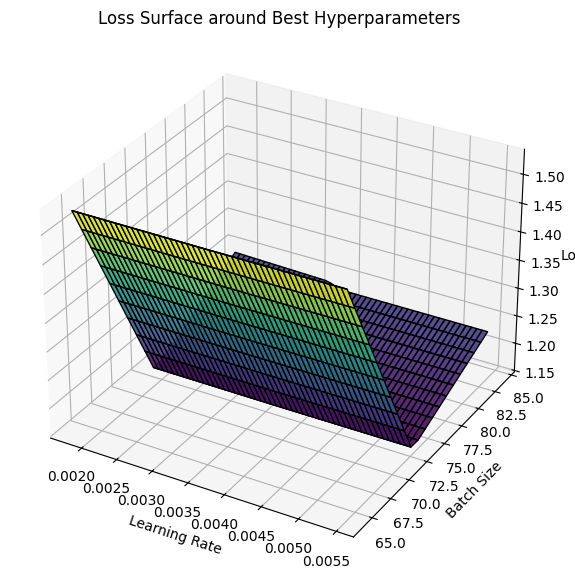

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define fine grid around best hyperparameters
lr_center = 0.00364
bs_center = 74

lr_range = np.linspace(lr_center * 0.5, lr_center * 1.5, 50)
bs_range = np.linspace(bs_center - 10, bs_center + 10, 50).astype(int)

LR, BS = np.meshgrid(lr_range, bs_range)
LOSS = np.zeros_like(LR)

# Compute loss for each (lr, bs) pair
for i in range(LR.shape[0]):
  for j in range(LR.shape[1]):
    loss = model.train(LR[i, j], BS[i, j])
    LOSS[i, j] = loss

# Create 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(LR, BS, LOSS, cmap='viridis', edgecolor='k', alpha=0.9)

ax.set_title('Loss Surface around Best Hyperparameters')
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Batch Size')
ax.set_zlabel('Loss')
plt.show()

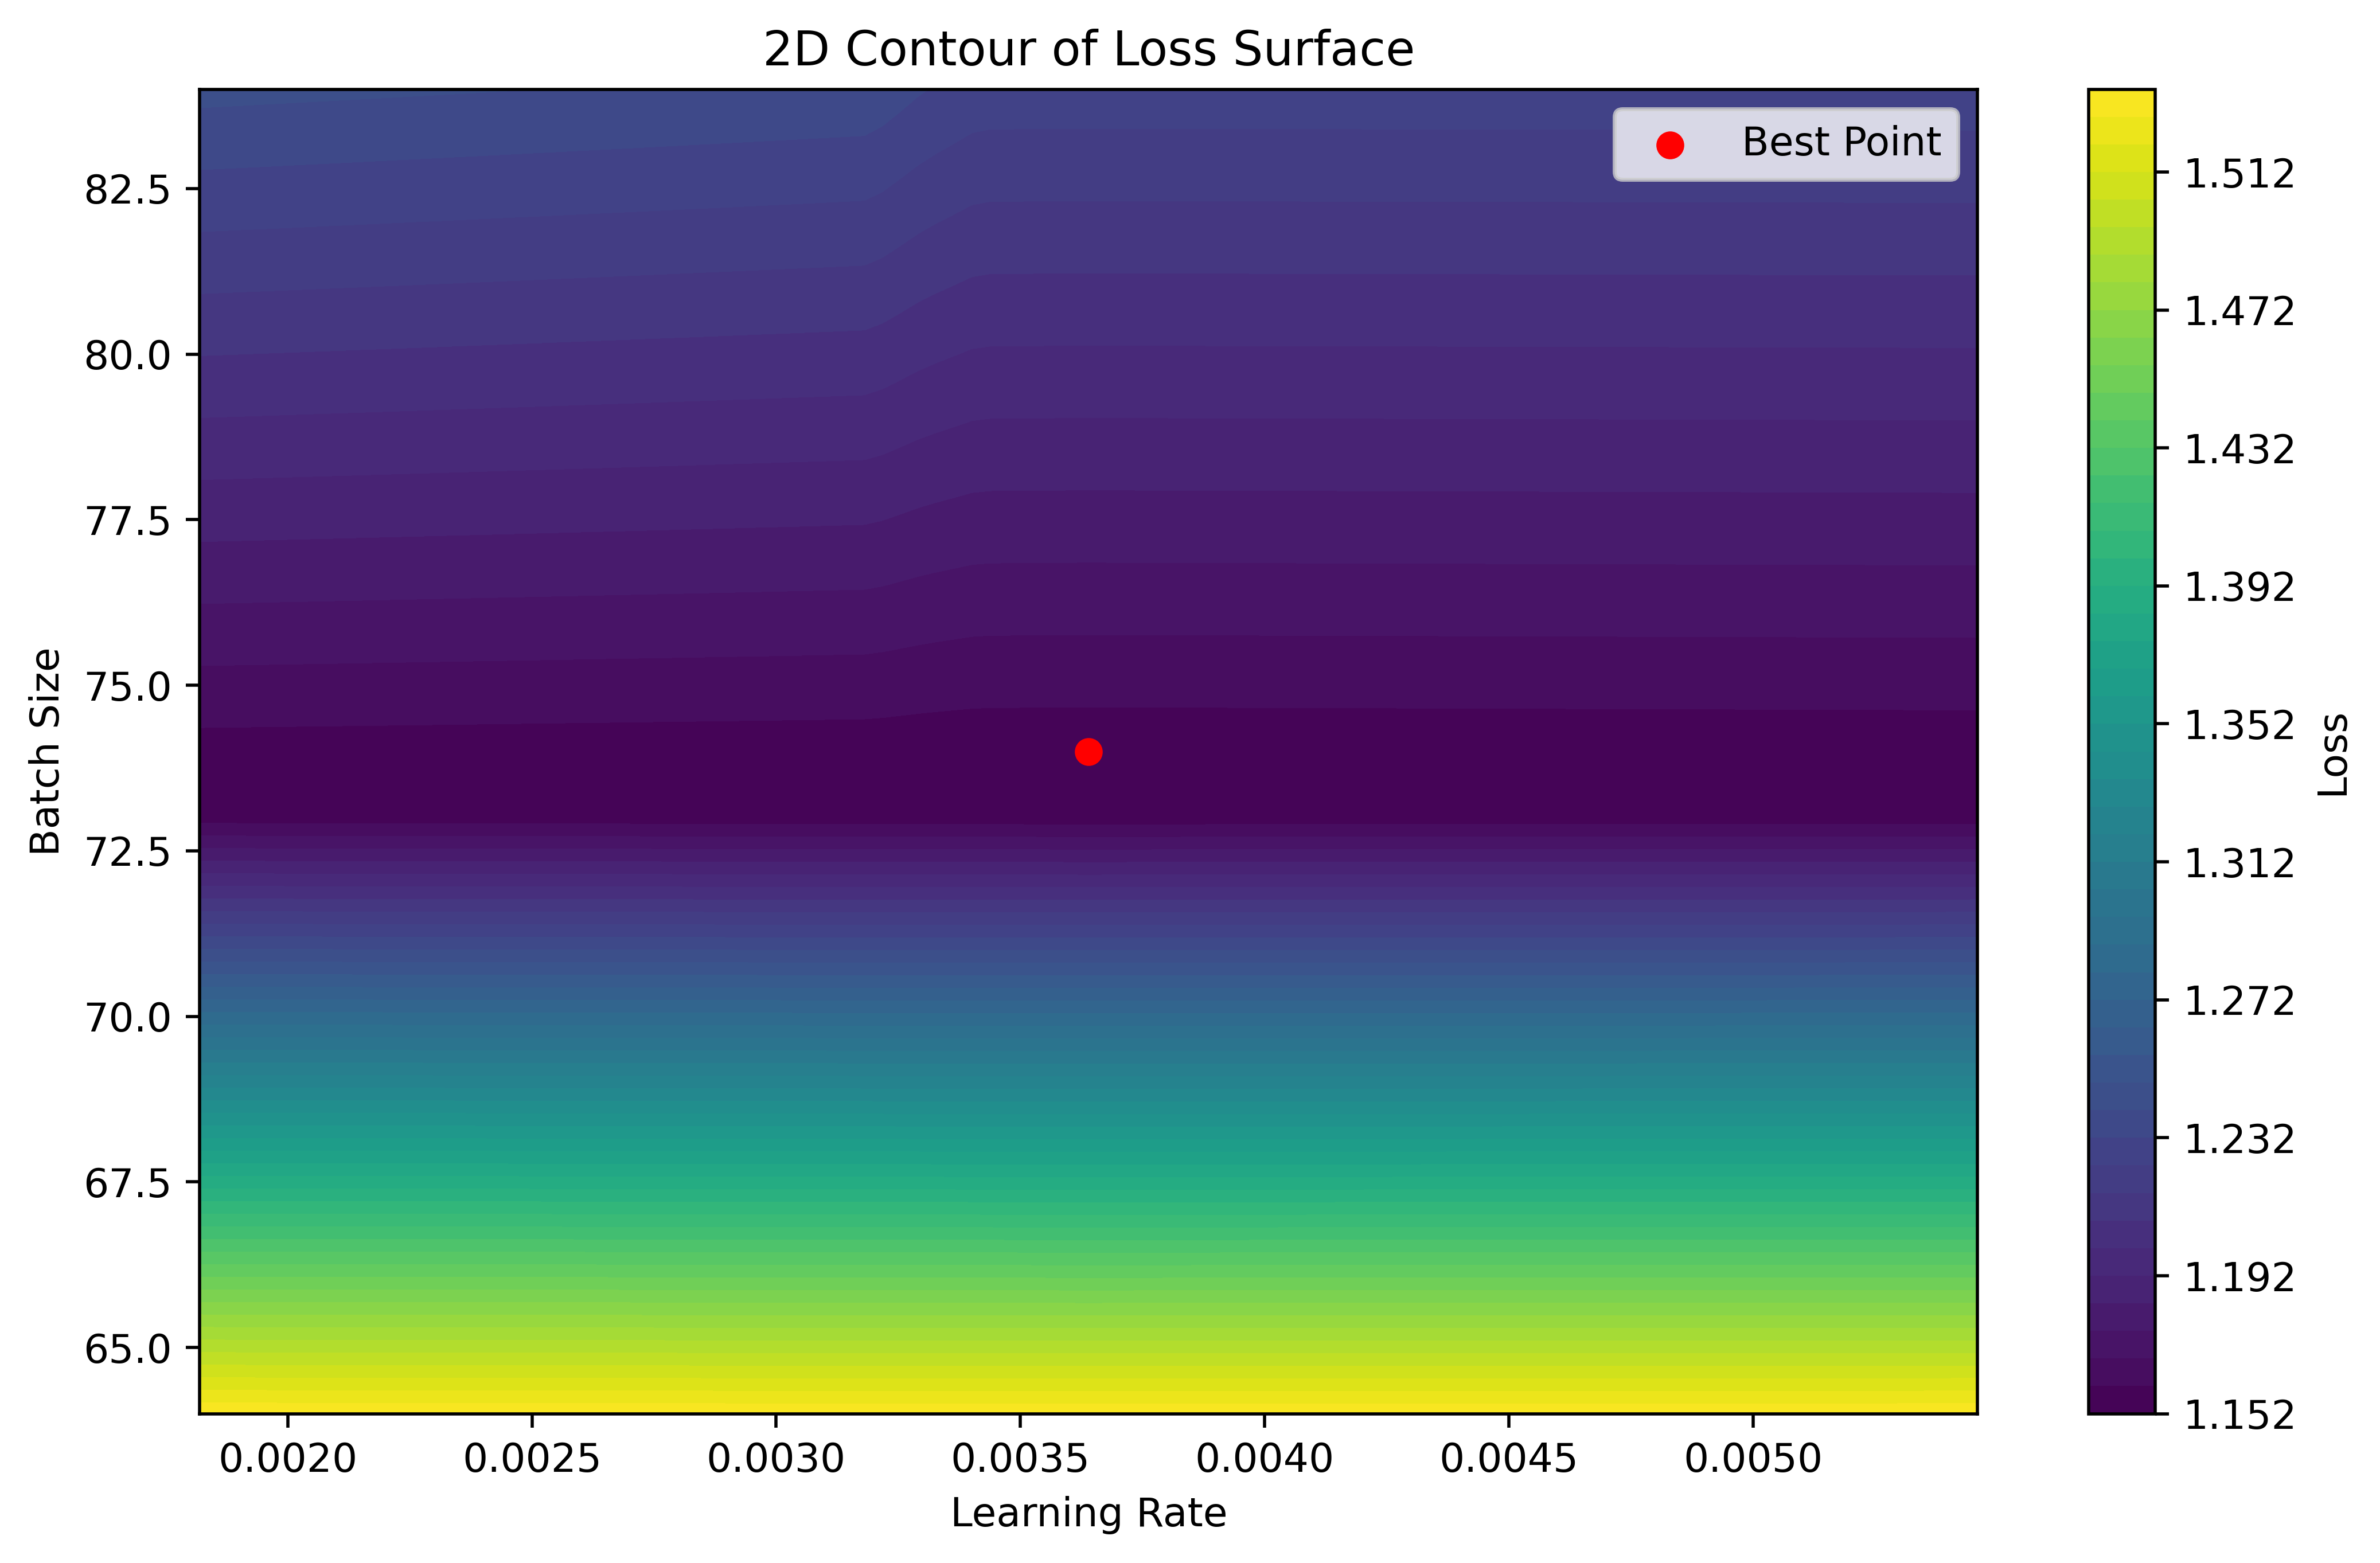

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Define the same fine grid as before
lr_center = 0.00364
bs_center = 74

lr_range = np.linspace(lr_center * 0.5, lr_center * 1.5, 100)
bs_range = np.linspace(bs_center - 10, bs_center + 10, 100).astype(int)

LR, BS = np.meshgrid(lr_range, bs_range)
LOSS = np.zeros_like(LR)

# Calculate loss values
for i in range(LR.shape[0]):
    for j in range(LR.shape[1]):
        LOSS[i, j] = model.train(LR[i, j], BS[i, j])

# Plot 2D contour
plt.figure(figsize=(10, 6), dpi=500)
contour = plt.contourf(LR, BS, LOSS, levels=50, cmap='viridis')
plt.colorbar(contour, label='Loss')
plt.scatter([lr_center], [bs_center], color='red', label='Best Point')
plt.xlabel('Learning Rate')
plt.ylabel('Batch Size')
plt.title('2D Contour of Loss Surface')
plt.legend()
plt.show()